In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tables
import glob
from traitlets.config.loader import Config
from ctapipe.containers import EventType
from ctapipe.io import read_table
from ctapipe.instrument import CameraGeometry, SubarrayDescription
from ctapipe.visualization import CameraDisplay
from ctapipe.image import (
        hillas_parameters,
        tailcuts_clean,
        apply_time_delta_cleaning
        )
from lstchain.io.config import get_cleaning_parameters
from lstchain.io.config import read_configuration_file
#from lstchain.io.io import read_single_camera_geometry
from lstchain.calib.camera.pixel_threshold_estimation import get_threshold_from_dl1_file

plt.rcParams.update({'font.size': 22})

In [16]:
def plot_img(ax, img, geom, text_label="signal [p.e.]", text_title="Image"):
    disp = CameraDisplay(geom, ax=ax)
    disp.image = img
    disp.add_colorbar(ax=ax, label=text_label)
    disp.cmap = 'gnuplot2'
    ax.set_title(text_title, fontsize=20)
    format_axes(ax)
    
def format_axes(ax):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")

In [17]:
def check_cleaning_with_pedestal_events(dl1_path, config_file_path="", config=None):
    clean_method_name = 'tailcuts_clean_with_pedestal_threshold'
    if config_file_path:
        config = read_configuration_file(config_file_path)
    
    # read cleaning parameters
    sigma = config[clean_method_name]['sigma']
    cleaning_params = get_cleaning_parameters(config, clean_method_name)
    pic_th, boundary_th, isolated_pixels, min_n_neighbors = cleaning_params
    
    
    pedestal_thresh = get_threshold_from_dl1_file(dl1_path, sigma)
    picture_th = np.clip(pedestal_thresh, pic_th, None)
    print(f"Fraction of pixel cleaning thresholds above picture thr.:"
          f"{np.sum(pedestal_thresh>pic_th) / len(pedestal_thresh):.3f}")
    
    delta_time = config[clean_method_name]['delta_time']
    print(config[clean_method_name])
    n_ped_events = 0
    n_survive_ped_clean = 0
    n_survive_delta_time = 0
    
    subarray_info = SubarrayDescription.from_hdf(dl1_path)
    #tel_id = config["allowed_tels"][0] if "allowed_tels" in config else 1
    #optics = subarray_info.tel[tel_id].optics
    camera_geometry = subarray_info.tel[1].camera.geometry
    #camera_geometry = read_single_camera_geometry(dl1_path, "LSTCam")
    tablename = "/dl1/event/telescope/parameters/LST_LSTCam"
    params = read_table(dl1_path, tablename)
    
    with tables.open_file(dl1_path, mode='r') as f:
        image_table = f.root['/dl1/event/telescope/image/LST_LSTCam']
        ucts_trigger_type = f.root['/dl1/event/telescope/parameters/LST_LSTCam'].col('ucts_trigger_type')
        for ii, row in enumerate(image_table):
            image = row['image']
            peak_time = row['peak_time']
            if params['event_type'][ii] == EventType.SKY_PEDESTAL.value:
                n_ped_events += 1
                # tailcuts clean
                signal_pixels = tailcuts_clean(camera_geometry,
                                            image,
                                            picture_thresh=picture_th,
                                            boundary_thresh=boundary_th,
                                            keep_isolated_pixels=isolated_pixels,
                                            min_number_picture_neighbors=min_n_neighbors)
            
                cleaning_img = image.copy()
                cleaning_img[~signal_pixels] = 0
                n_pixels = np.count_nonzero(signal_pixels)
            
                if n_pixels > 0:
                    n_survive_ped_clean += 1
                if n_pixels > 0:
                    cleaned_pixel_times = peak_time
                    cleaned_pixel_times[~signal_pixels] = np.nan
                    new_mask = apply_time_delta_cleaning(
                                                 camera_geometry,
                                                 signal_pixels,
                                                 cleaned_pixel_times,
                                                 1,
                                                 delta_time)
                    signal_pixels = new_mask
                    time_cleaning_img = cleaning_img.copy()
                    time_cleaning_img[~signal_pixels] = 0
                   
                    n_pixels = np.count_nonzero(signal_pixels)        
                    if n_pixels > 0:
                        n_survive_delta_time += 1
                        
    print(n_ped_events, n_survive_ped_clean, n_survive_delta_time)
    print("N pedestal events {}".format(n_ped_events))
    print("N pedestal events survived tailcut cleaning {}".format(n_survive_ped_clean))
    print("N pedestal events survived tailcut + delta time cleaning {}".format(n_survive_delta_time), end=" ")
    percent_survive = (n_survive_delta_time/n_ped_events)*100
    print("{:.2f} %".format(percent_survive))
    
def show_images_cleaning_with_pedestal_events(dl1_path, config_file_path="", config=None):
    clean_method_name = 'tailcuts_clean_with_pedestal_threshold'
    if config_file_path:
        config = read_configuration_file(config_file_path)
    
    sigma = config[clean_method_name]['sigma']
    cleaning_params = get_cleaning_parameters(config, clean_method_name)
    pic_th, boundary_th, isolated_pixels, min_n_neighbors = cleaning_params
    
    
    pedestal_thresh = get_threshold_from_dl1_file(dl1_path, sigma)
    picture_th = np.clip(pedestal_thresh, pic_th, None)
    print(f"Fraction of pixel cleaning thresholds above picture thr.:"
                 f"{np.sum(pedestal_thresh>pic_th) / len(pedestal_thresh):.3f}")
    
    delta_time = config[clean_method_name]['delta_time']
    print(config[clean_method_name])

    
    subarray_info = SubarrayDescription.from_hdf(dl1_path)
    #tel_id = config["allowed_tels"][0] if "allowed_tels" in config else 1
    #optics = subarray_info.tel[tel_id].optics
    camera_geometry = subarray_info.tel[1].camera.geometry
    #camera_geometry = read_single_camera_geometry(dl1_path, "LSTCam")
    tablename = "/dl1/event/telescope/parameters/LST_LSTCam"
    params = read_table(dl1_path, tablename)
    n_events = 0
    n_survive = 0
    with tables.open_file(dl1_path, mode='r') as f:
        image_table = f.root['/dl1/event/telescope/image/LST_LSTCam'][:5000]
        ucts_trigger_type = f.root['/dl1/event/telescope/parameters/LST_LSTCam'].col('ucts_trigger_type')[:5000]
        for ii, row in enumerate(image_table):
            image = row['image']
            peak_time = row['peak_time']
            if params['event_type'][ii] == EventType.SKY_PEDESTAL.value:
                n_events += 1
                signal_pixels = tailcuts_clean(camera_geometry,
                                                image,
                                                picture_thresh=picture_th,
                                                boundary_thresh=boundary_th,
                                                keep_isolated_pixels=isolated_pixels,
                                                min_number_picture_neighbors=min_n_neighbors)
            
                cleaning_img = image.copy()
                cleaning_img[~signal_pixels] = 0
                n_pixels = np.count_nonzero(signal_pixels)
            
                # delta_time cleaning, we require at least one
                # neighbor within delta_time to accept a pixel in the image:
                if n_pixels > 0:
                    cleaned_pixel_times = peak_time
                    cleaned_pixel_times[~signal_pixels] = np.nan
                    new_mask = apply_time_delta_cleaning(
                                                 camera_geometry,
                                                 signal_pixels,
                                                 cleaned_pixel_times,
                                                 1,
                                                 delta_time)
                    signal_pixels = new_mask
                    time_cleaning_img = cleaning_img.copy()
                    time_cleaning_img[~signal_pixels] = 0
                    cleaning_img = time_cleaning_img
                    n_pixels = np.count_nonzero(signal_pixels)
                if n_pixels > 0:
                    n_survive += 1
                    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
                    plot_img(ax[0], image, camera_geometry)
                    plot_img(ax[1], cleaning_img, camera_geometry, text_title="Cleaning")
                    plt.show()
                    
        print("N events survived cleaning per pedestal events : {}/{}".format(n_survive, n_events))

# Pedestal events

Good way to check performance of cleaning is check how many pedestal events will survive cleaning
* shoudl be < 3-5 %

# Crab

Fraction of pixel cleaning thresholds above picture thr 6: 1.000
Fraction of pixel cleaning thresholds above picture thr 8: 1.000


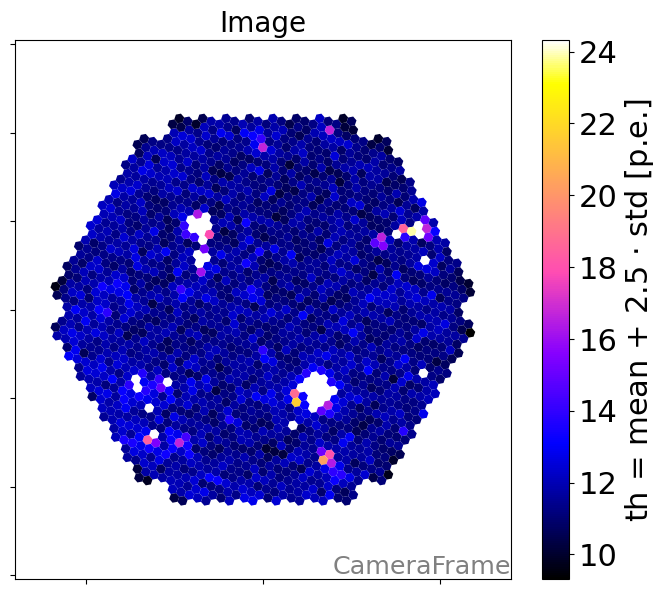

In [20]:
sigma = 2.5
dl1_filename = "/fefs/aswg/data/real/DL1/20*/v*/tailcut84/dl1_LST-1.Run09686.0010.h5"
dl1_path = glob.glob(dl1_filename)[0]

# calculate mean and standard deviation of each pixel's charge in interleaved pedestals with sigma=2.5.
pedestal_thresh = get_threshold_from_dl1_file(dl1_path, sigma)

subarray_info = SubarrayDescription.from_hdf(dl1_path)
#tel_id = config["allowed_tels"][0] if "allowed_tels" in config else 1
#optics = subarray_info.tel[tel_id].optics
camera_geometry = subarray_info.tel[1].camera.geometry
#camera_geometry = read_single_camera_geometry(dl1_path, "LSTCam")
fig, ax = plt.subplots(figsize=(8, 7))
plot_img(ax, pedestal_thresh, camera_geometry, text_label="th = mean + 2.5 $\cdot$ std [p.e.]")

print(f"Fraction of pixel cleaning thresholds above picture thr 6: "
      f"{np.sum(pedestal_thresh>6) / len(pedestal_thresh):.3f}")

print(f"Fraction of pixel cleaning thresholds above picture thr 8: "
      f"{np.sum(pedestal_thresh>8) / len(pedestal_thresh):.3f}")

Check how pedestal tailcuts with delta time cleaning works with pedestal events   
* Cleaning 6-3
* Cleaning 8-4
* Cleaning 10-5

delta time = 2 ns

### 6-3

Check how pedestal tailcuts with delta time cleaning works with pedestal events  

In [22]:
#dl1_path = "/fefs/aswg/data/real/DL1/20201120/v0.7.3/tailcut84/dl1_LST-1.Run02969.0010.h5"
#config_file_63 = "/fefs/aswg/lstosa/config_files_lstchain/lstchain_standard_config.json"
#check_cleaning_with_pedestal_events(dl1_path, config_file_63)

In [ ]:
#dl1_path = "/fefs/aswg/data/real/DL1/20201120/v0.7.3/tailcut84/dl1_LST-1.Run02969.0010.h5"
#config_file_63 = "/fefs/aswg/lstosa/config_files_lstchain/lstchain_standard_config.json"
#show_images_cleaning_with_pedestal_events(dl1_path, config_file_63)

### 8-4

In [ ]:
#dl1_path = "/fefs/aswg/data/real/DL1/20201120/v0.7.3/tailcut84/dl1_LST-1.Run02969.0010.h5"
#config_file_84 = "/fefs/aswg/lstosa/config_files_lstchain/lstchain_standard_config_tailcut84.json"
#check_cleaning_with_pedestal_events(dl1_path, config_file_84)

In [ ]:
config = Config({
    "tailcuts_clean_with_pedestal_threshold": {
        'picture_thresh': 10,
        'boundary_thresh': 5, 
        'sigma': 2.5, 
        'keep_isolated_pixels': False, 
        'min_number_picture_neighbors': 2, 
        'use_only_main_island': False, 
        'delta_time': 2
    }
}) 
check_cleaning_with_pedestal_events(dl1_path, config_file_path=False, config=config)


In [ ]:
show_images_cleaning_with_pedestal_events(dl1_path, config_file_path=False, config=config)

# Mrk 421

In [ ]:
sigma = 2.5
dl1_path = "/fefs/aswg/data/real/DL1/20210316/v0.7.1/tailcut84/dl1_LST-1.Run04097.0004.h5"

# calculate mean and standard deviation of each pixel's charge in interleaved pedestals with sigma=2.5.
pedestal_thresh = get_threshold_from_dl1_file(dl1_path, sigma)
camera_geometry = read_single_camera_geometry(dl1_path, "LSTCam")
fig, ax = plt.subplots(figsize=(8, 7))
plot_img(ax, pedestal_thresh, camera_geometry)

print(f"Fraction of pixel cleaning thresholds above picture thr 6: "
      f"{np.sum(pedestal_thresh>6) / len(pedestal_thresh):.3f}")
print(f"Fraction of pixel cleaning thresholds above picture thr 8: "
      f"{np.sum(pedestal_thresh>8) / len(pedestal_thresh):.3f}")

### 6-3

In [ ]:
dl1_path = "/fefs/aswg/data/real/DL1/20210316/v0.7.1/tailcut84/dl1_LST-1.Run04097.0004.h5"
config_file_63 = "/fefs/aswg/lstosa/config_files_lstchain/lstchain_standard_config.json"
check_cleaning_with_pedestal_events(dl1_path, 
                                    config_file_63)

### 8-4

In [ ]:
dl1_path = "/fefs/aswg/data/real/DL1/20210316/v0.7.1/tailcut84/dl1_LST-1.Run04097.0004.h5"
config_file_84 = "/fefs/aswg/lstosa/config_files_lstchain/lstchain_standard_config_tailcut84.json"
check_cleaning_with_pedestal_events(dl1_path, 
                                    config_file_84)

# Exercises :
1. Check pedestal events dl1_LST-1.Run04097.0004.h5" with pedestal tailcuts clean method picture_threshold = 7, boundary_threshold=3.5 and sigma = 2.5, delta_time = 2